# Model Selection, Underfitting, and Overfitting

Explore these concepts interactively
by fitting polynomials to data

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

Use the following cubic polynomial to generate the labels
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [2]:
max_degree = 20  # Maximum degree of the polynomial
n_train, n_test = 100, 100  # Training and test dataset sizes
true_w = np.zeros(max_degree)  # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# Shape of `labels`: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

Take a look at the first 2 samples

In [4]:
# Convert from NumPy ndarrays to tensors
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 2.2877],
         [-0.8669]]),
 tensor([[ 1.0000e+00,  2.2877e+00,  2.6167e+00,  1.9953e+00,  1.1412e+00,
           5.2212e-01,  1.9907e-01,  6.5058e-02,  1.8604e-02,  4.7288e-03,
           1.0818e-03,  2.2497e-04,  4.2889e-05,  7.5473e-06,  1.2333e-06,
           1.8808e-07,  2.6892e-08,  3.6188e-09,  4.5992e-10,  5.5375e-11],
         [ 1.0000e+00, -8.6691e-01,  3.7576e-01, -1.0858e-01,  2.3533e-02,
          -4.0802e-03,  5.8952e-04, -7.3009e-05,  7.9114e-06, -7.6205e-07,
           6.6063e-08, -5.2064e-09,  3.7612e-10, -2.5082e-11,  1.5531e-12,
          -8.9760e-14,  4.8633e-15, -2.4800e-16,  1.1944e-17, -5.4497e-19]]),
 tensor([10.0797,  2.2459]))

Implement a function to evaluate the loss on a given dataset

In [5]:
def evaluate_loss(net, data_iter, loss):  
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

Define the training function

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

Third-Order Polynomial Function Fitting (Normal)

weight: [[ 5.005434   1.1886789 -3.4084394  5.595781 ]]


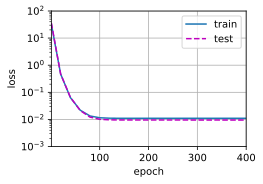

In [7]:
# Pick the first four dimensions, i.e., 1, x, x^2/2!, x^3/3! from the
# polynomial features
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

Linear Function Fitting (Underfitting)

weight: [[3.205638  5.2455077]]


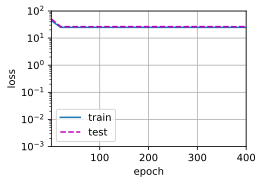

In [8]:
# Pick the first two dimensions, i.e., 1, x, from the polynomial features
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

Higher-Order Polynomial Function Fitting  (Overfitting)

weight: [[ 5.0189886   1.2516079  -3.4657423   5.2974257   0.02579288  0.67940784
   0.3973834  -0.02141819  0.2809177  -0.01716929  0.16963552  0.19000316
   0.16791385  0.03271939 -0.07893809  0.03528467  0.1316716  -0.02346263
   0.083594   -0.09365698]]


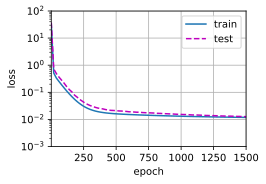

In [9]:
# Pick all the dimensions from the polynomial features
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)